# Project Tcells onto EMTAB2319
## Xiaonan Wang
## 04Jul2018

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pdA
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

Running Scanpy version 0.2.3 on 2018-07-04 12:47.


# T cells bulk data

In [ ]:
## Read in bulk data
Bulk_data = sc.read("/servers/bio-shares-2/gottgens/Xiaonan/T_cells_data_E_MTAB_2319/EMTAB_2319_cnt.txt", cache=True, delimiter="\t")
Bulk_data.var_names = np.genfromtxt("genes.tsv", dtype=str)[:, 1]
Bulk_data.var['Ensembl'] = np.genfromtxt("genes.tsv", dtype=str)[:, 0]
Bulk_data.smp_names = np.genfromtxt("/servers/bio-shares-2/gottgens/Xiaonan/T_cells_data_E_MTAB_2319/EMTAB_2319_SampleNames.txt", dtype=str)
print(Bulk_data.smp_names[0:5])
print(Bulk_data.var_names[0:5])
CT_labels = np.genfromtxt('/servers/bio-shares-2/gottgens/Xiaonan/T_cells_data_E_MTAB_2319/EMTAB_2319_CT.txt', delimiter='\t', dtype=str)
Bulk_data.smp['CT_labels'] = CT_labels
surM_labels = np.genfromtxt('/servers/bio-shares-2/gottgens/Xiaonan/T_cells_data_E_MTAB_2319/EMTAB_2319_SurM.txt', delimiter='\t', dtype=str)
Bulk_data.smp['surM_labels'] = surM_labels

## Calculate QC parameters
mito_genes = np.array([name for name in Bulk_data.var_names if name.startswith('MT-')])
print(mito_genes)
#for each cell compute fraction of counts in mito genes vs. all genes
Bulk_data.smp['percent_mito'] = np.sum(Bulk_data[:, mito_genes].X, axis=1) / np.sum(Bulk_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
Bulk_data.smp['n_counts'] = np.sum(Bulk_data.X, axis=1)
Bulk_data.smp['log2_n_counts'] = np.log2(np.sum(Bulk_data.X, axis=1))
Bulk_data.smp['n_genes'] = (Bulk_data.X!=0).astype(int).sum(axis=1)
axs = sc.pl.scatter(Bulk_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(Bulk_data, x='n_counts', y='n_genes')

## Filter and normalisation
sc.pp.filter_genes(Bulk_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(Bulk_data)

## Select for highly variable genes
filter_result = sc.pp.filter_genes_dispersion(Bulk_data.X, flavor='cell_ranger', n_top_genes=2000, log=False)

sc.pl.filter_genes_dispersion(filter_result, log=True)
Bulk_data = Bulk_data[:, filter_result.gene_subset] 

sc.pp.log1p(Bulk_data)

Bulk_data = sc.pp.regress_out(Bulk_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(Bulk_data)

## PCA
sc.tl.pca(Bulk_data)

## TSNE
sc.tl.tsne(Bulk_data, n_jobs=1, perplexity = 15)

Bulk_data.write('./write/Bulk_data.h5'')

In [5]:
Bulk_data = sc.read('./write/Bulk_data.h5')
Bulk_data.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


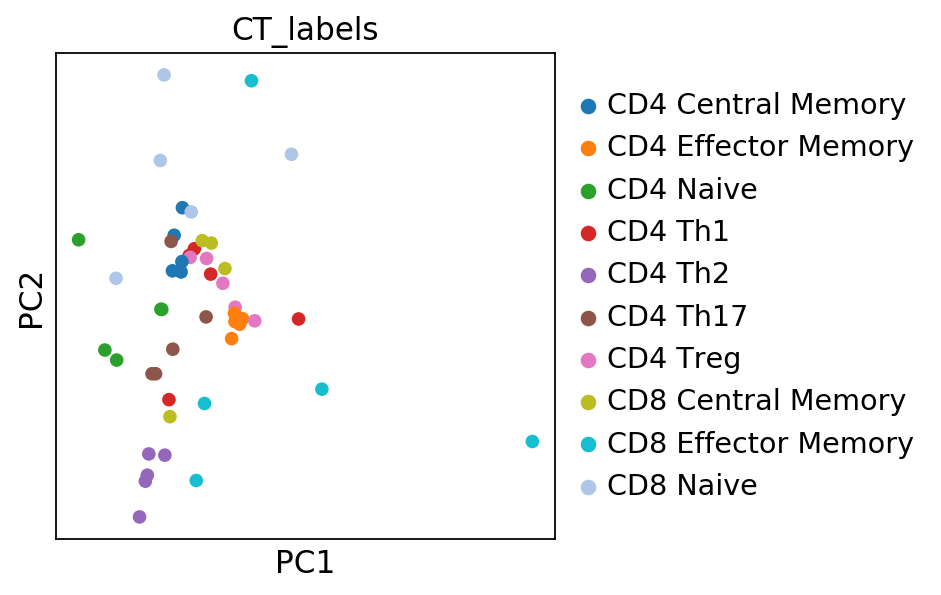

In [9]:
sc.pl.pca_scatter(Bulk_data, color=['CT_labels'], size=150)

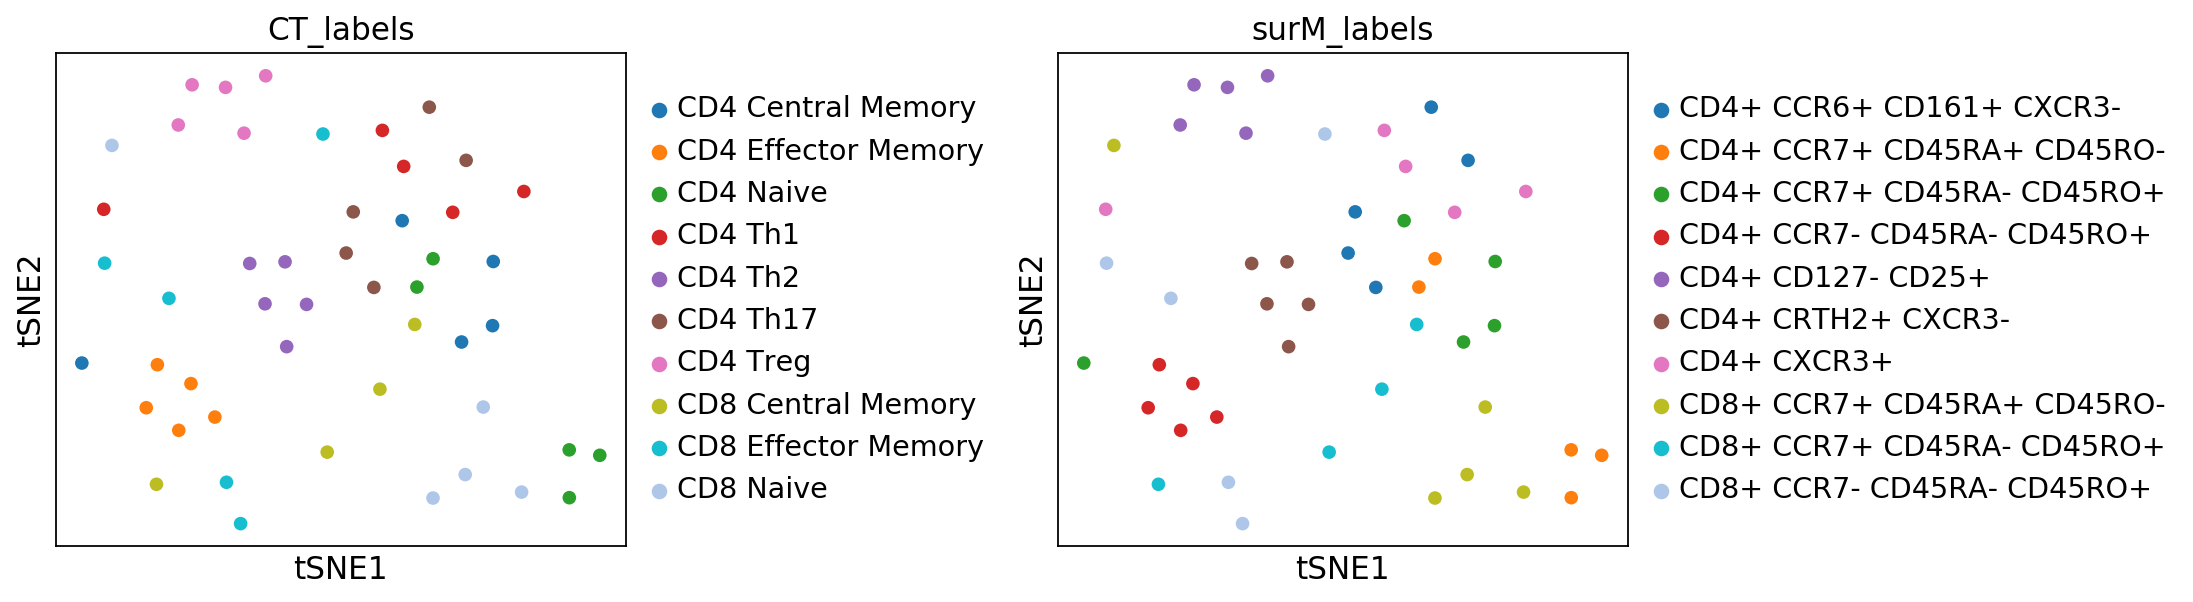

In [12]:
ax = sc.pl.tsne(Bulk_data, color=['CT_labels', 'surM_labels'], legend_loc='right margin', size=150, wspace=0.6)

# Predict T cells from bulk

In [48]:
Tcells_data_corrected = sc.read('./write/Tcells_corrected.h5', cache=True)

In [9]:
Bulk_data = sc.read('./write/Bulk_data.h5', cache=True)

In [10]:
Bulk_data_new = Bulk_data[((Bulk_data.smp['CT_labels'] != 'CD4 Th1') & (Bulk_data.smp['CT_labels'] != 'CD4 Th17') & (Bulk_data.smp['CT_labels'] != 'CD4 Th2')),]

In [6]:
hvg_OL = np.intersect1d(Tcells_data_corrected.var_names,Bulk_data.var_names)
print(len(hvg_OL))

301


In [7]:
Tcells_index = [np.where(Tcells_data_corrected.var_names==x)[0][0] for x in hvg_OL]
Bulk_index = [np.where(Bulk_data.var_names==x)[0][0] for x in hvg_OL]

In [8]:
Bulk_data4 = Bulk_data4[:, Bulk_index]

In [11]:
np.savetxt("/servers/bio-shares-2/gottgens/Xiaonan/TenX_scmap_test/Tcells_to_Bulk/Tcells_bulk_Bulk4_CN.txt", Bulk_data4.smp_names, fmt="%s")
np.savetxt("/servers/bio-shares-2/gottgens/Xiaonan/TenX_scmap_test/Tcells_to_Bulk/Tcells_bulk_Bulk4_labels.txt", Bulk_data4.smp['CT_labels'], fmt="%s")

In [12]:
np.savetxt("Tcells_bulk_cnt4.txt", np.concatenate((Tcells_data_corrected.X[:,Tcells_index], Bulk_data4.X), axis=0))

### scmap code
Here scmap code is in J:/Xiaonan/R_code/TenxG1/scmap_code.R

In [13]:
Tcells_data_corrected = sc.read('./write/Tcells_corrected.h5', cache=True)

In [16]:
scmap_set4 = np.genfromtxt("/servers/bio-shares-4/gottgens/Xiaonan/TenX_scmap_test/Tcells_to_Bulk/scmap_set4.txt", delimiter="\t", dtype=str)

In [18]:
Tcells_data_corrected.obs['scmap_set4'] =  scmap_set4

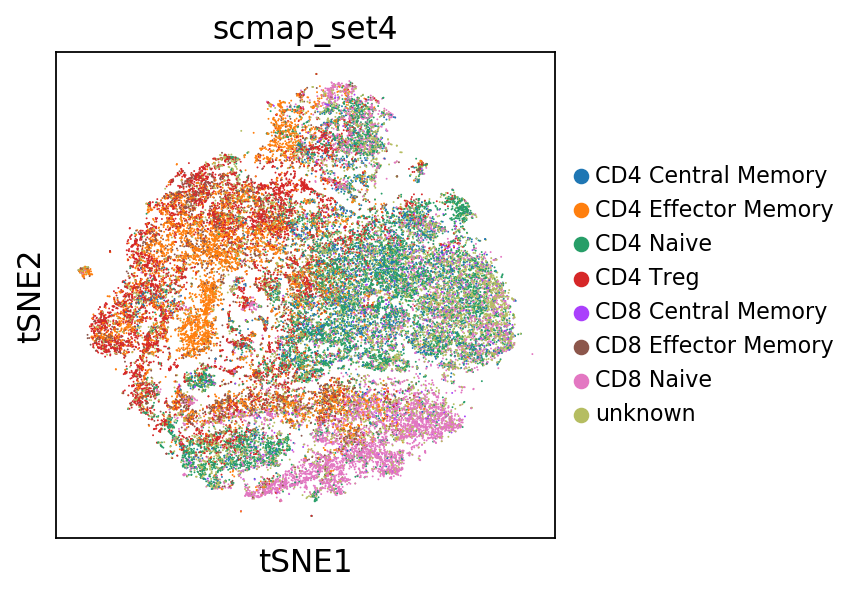

In [20]:
axs = sc.pl.tsne(Tcells_data_corrected, color=['scmap_set4'], legend_loc='right margin', legend_fontsize=10)

# Predict PBMC T cells from bulk

In [11]:
Tcells_PBMC_data = sc.read('Tcells_PBMC_data')

In [12]:
hvg_OL = np.intersect1d(Tcells_PBMC_data.var_names,Bulk_data.var_names)
print(len(hvg_OL))

380


In [13]:
PBMC_Tcells_index = [np.where(Tcells_PBMC_data.var_names==x)[0][0] for x in hvg_OL]
Bulk_index = [np.where(Bulk_data.var_names==x)[0][0] for x in hvg_OL]

In [22]:
np.savetxt("PBMC_Tcells_bulk_cnt4.txt", np.concatenate((Tcells_PBMC_data.X[:,PBMC_Tcells_index], Bulk_data4.X[:,Bulk_index]), axis=0))

In [19]:
np.savetxt("/servers/bio-shares-2/gottgens/Xiaonan/TenX_scmap_test/PBMC_Tcells_to_Bulk/Tcells_bulk_Tcells_CN.txt", Tcells_PBMC_data.smp_names, fmt="%s")
np.savetxt("/servers/bio-shares-2/gottgens/Xiaonan/TenX_scmap_test/PBMC_Tcells_to_Bulk/Tcells_bulk_GN.txt", Tcells_PBMC_data.var_names[PBMC_Tcells_index], fmt="%s")

### scmap code
Here scmap code is in J:/Xiaonan/R_code/TenxG1/scmap_code.R

In [22]:
Tcells_PBMC_data = sc.read('./write/Tcells_PBMC_data.h5', cache=True)

In [24]:
scmap_set4 = np.genfromtxt("/servers/bio-shares-4/gottgens/Xiaonan/TenX_scmap_test/PBMC_Tcells_to_Bulk/scmap_set4.txt", delimiter="\t", dtype=str)

In [25]:
Tcells_PBMC_data.obs['scmap_set4'] =  np.array(scmap_set4)

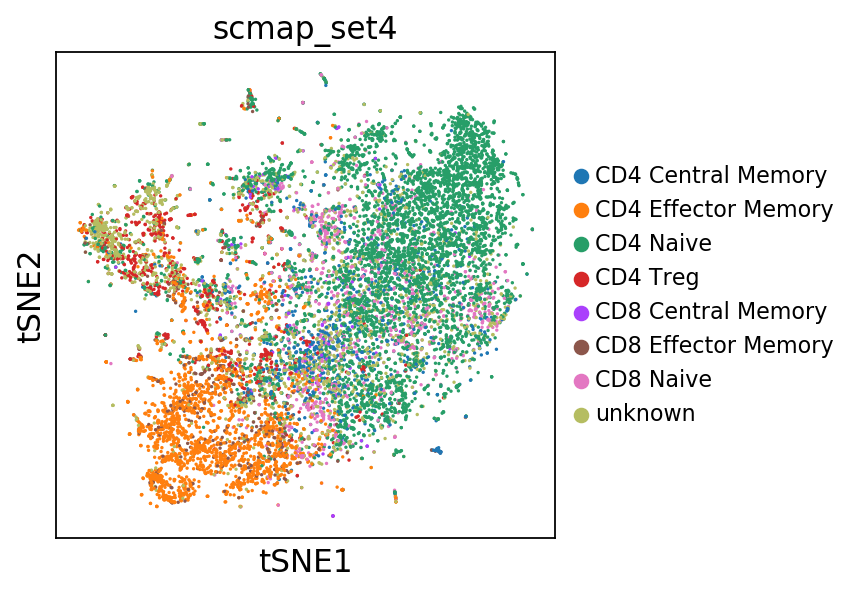

In [27]:
axs = sc.pl.tsne(Tcells_PBMC_data, color=['scmap_set4'], legend_loc='right margin', legend_fontsize=10)

# Read and Write

In [28]:
Tcells_data_corrected.write('./write/Tcells_corrected.h5')
Tcells_PBMC_data.write('./write/Tcells_PBMC_data.h5')